fig1d: similarity between fetal skin, organoid and adult skin

# Import and settings

In [31]:
%load_ext autoreload
%autoreload 2

import os, re, gc, joblib
import numpy as np
import numpy_groupies as npg
import pandas as pd

import anndata
import scanpy as sc
import sctk as sk

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from sklearn.decomposition import PCA

In [3]:
import umap

In [4]:
import plotnine as pln

In [5]:
np.set_printoptions(linewidth=150)

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42

sc.settings.verbosity = 0
sk.set_figsize((4, 4))

In [6]:
from time import localtime, strftime


def timestamp(date_only=True):
    stamp_format = "%Y%m%d" if date_only else "%Y%m%d-%H%M"
    return strftime(stamp_format, localtime())

# Load data

In [7]:
adt_ad = sc.read("../data/h5ad/Healthy_all_data.h5ad")

In [8]:
org_ad = sc.read("../data/h5ad/organoid_day6_8_10_13_29_48_133.cellxgene.h5ad")

In [9]:
fsk_ad = sc.read("../20210611_final_object/fetal_skin.norm.maternal_removed.20220202.h5ad")

In [10]:
ad_lr = joblib.load("../20200804_fig1/lr_model/pooled_adult_lognorm_LR.pkl")

In [11]:
ad_lr.classes_

array(['adult_B', 'adult_C_Melanocyte', 'adult_DC1', 'adult_DC2', 'adult_F1', 'adult_F2', 'adult_F3', 'adult_ILC1', 'adult_ILC1_NK', 'adult_ILC2_3',
       'adult_Inf_mono', 'adult_LC_1', 'adult_LC_2', 'adult_LC_3', 'adult_LC_4', 'adult_LE1', 'adult_LE2', 'adult_Macro_1', 'adult_Macro_2',
       'adult_Mast', 'adult_MigDC', 'adult_Mono', 'adult_NK', 'adult_Pericyte_1_non_inflamm', 'adult_Pericyte_2_inflamm', 'adult_Plasma',
       'adult_Schwaan_1_Stroma_Schwan_myelinating', 'adult_Schwaan_2_non_myelinating', 'adult_Schwann', 'adult_Tc', 'adult_Th', 'adult_Treg',
       'adult_VE1', 'adult_VE2', 'adult_VE3', 'adult_c1', 'adult_c2', 'adult_c3', 'adult_c4', 'adult_c5', 'adult_c6', 'adult_c7', 'adult_c8',
       'adult_moDC_1', 'adult_moDC_2', 'adult_moDC_3', 'adult_pDC'], dtype=object)

In [12]:
org_lr = joblib.load("../20210611_final_object/organoid.joint_annot.lognorm.pkl")

In [13]:
org_lr.classes_ = ("organoid_" + pd.Series(org_lr.classes_).astype(str)).values

In [14]:
org_lr.classes_

array(['organoid_Adipocytes', 'organoid_Basal', 'organoid_Basal POSTN+', 'organoid_Basal SHH+', 'organoid_Companion layer',
       'organoid_Cuticle/cortex', 'organoid_Dermal condensate', 'organoid_Dermal papillia', 'organoid_Early fibroblasts FRZB+',
       'organoid_Early fibroblasts HOXC5', 'organoid_Early myocytes', 'organoid_Fibroblasts POSTN+', 'organoid_Immature basal',
       'organoid_Immature suprabasal', 'organoid_Inner root sheath', 'organoid_Melanoblasts', 'organoid_Melanocytes', 'organoid_Merkel cells',
       'organoid_Myelinating Schwann cells', 'organoid_Myoblasts', 'organoid_Myocytes', 'organoid_Neuroepithelial cells',
       'organoid_Neuron progenitors', 'organoid_Neuron progenitors SPP1+', 'organoid_Outer root sheath', 'organoid_Periderm',
       'organoid_Pre-dermal condensate', 'organoid_Proliferating melanoblasts', 'organoid_Schwann cells/Schwann precursors',
       'organoid_Secreting neuron', 'organoid_Smooth muscle/Pericytes', 'organoid_Suprabasal IFE', 'orga

In [15]:
fsk_lr = joblib.load("../20210611_final_object/fetal_skin.fig1b_annotation_20220202.lognorm.pkl")

In [16]:
fsk_lr.classes_[2] = "Dermal papillia"

In [17]:
fsk_lr.classes_ = ("fetal_" + pd.Series(fsk_lr.classes_).astype(str)).values

In [18]:
fsk_lr.classes_

array(['fetal_Adipocyte', 'fetal_B cell', 'fetal_Dermal papillia', 'fetal_Erythroid', 'fetal_Fibroblast', 'fetal_ILC', 'fetal_Keratinocyte',
       'fetal_Langerhans cell', 'fetal_Lymphatic endothelium', 'fetal_Macrophage', 'fetal_Mast cell', 'fetal_Megakaryocyte', 'fetal_Melanocyte',
       'fetal_Monocyte', 'fetal_Mural cell', 'fetal_Myofibroblast', 'fetal_Neuronal cells', 'fetal_Neutrophil', 'fetal_Progenitor',
       'fetal_Schwann cell', 'fetal_Skeletal muscle', 'fetal_T cell', 'fetal_Vascular endothelium', 'fetal_cDC', 'fetal_pDC'], dtype=object)

# Process

## prepare organoid

In [19]:
sk.LR_predict(org_ad, org_lr, use_rep="X", min_prob=0, key_added="org_annot0")
sk.LR_predict(org_ad, org_lr, use_rep="X", min_prob=0.3, key_added="org_annot30")

18866 features used for prediction
18866 features used for prediction


In [21]:
org_fsk_annot0 = sk.LR_predict(
    org_ad, fsk_lr, use_rep="X", min_prob=0, key_added="fsk_annot0", return_predict=True
)
org_fsk_annot30 = sk.LR_predict(
    org_ad, fsk_lr, use_rep="X", min_prob=0.3, key_added="fsk_annot30", return_predict=True
)

20320 features used for prediction
20320 features used for prediction


In [22]:
%%capture
sk.plot_embedding(org_ad, basis="umap_bk", groupby="org_annot30");

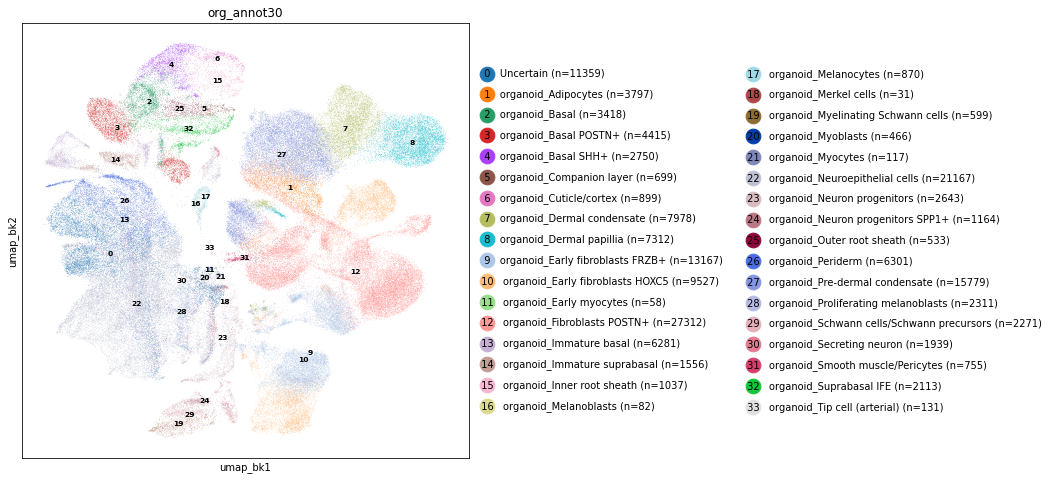

In [23]:
org_ad.uns["org_annot30_colors"][-1] = "#E0E0E0"
sk.plot_embedding(org_ad, basis="umap_bk", groupby="org_annot30", figsize=(8, 8), annot="full");

In [24]:
org_ad.obs.day.cat.categories

Index(['day-6', 'day-8', 'day-10', 'day-13', 'day-29', 'day-48', 'day-85',
       'day-133'],
      dtype='object')

In [25]:
k_org1 = ~org_ad.obs.day.isin(["day-6", "day-8", "day-10"])

In [26]:
org_ad1 = org_ad[k_org1].copy()

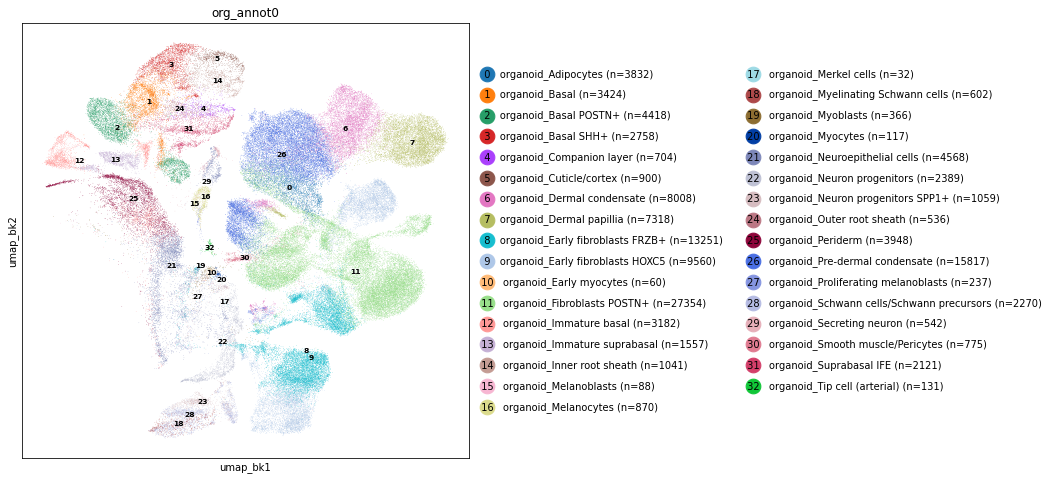

In [28]:
sk.plot_embedding(org_ad1, basis="umap_bk", groupby="org_annot0", figsize=(8, 8), annot="full");

save

In [30]:
org_ad1

AnnData object with n_obs × n_vars = 123835 × 38072
    obs: 'day', 'sample_id', 'strain', 'version', 'week', 'nh3_annot1', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'pass_auto_filter', 'scrublet_score', 'scrublet_score_z', 'cluster_scrublet_score', 'bh_pval', 'scrublet_done', 'doublet', 'seurat_clusters', 'fsk_annot1_min30', 'fsk_annot1_min30_prob', 'fsk_annot2_min30', 'fsk_annot2_min30_prob', 'day8to13', 'org_annot0', 'org_annot0_prob', 'org_annot30', 'org_annot30_prob', 'fsk_annot0', 'fsk_annot0_prob', 'fsk_annot30', 'fsk_annot30_prob'
    var: 'mito', 'ribo', 'hb', 'n_counts', 'n_cells'
    uns: 'org_annot30_colors', 'org_annot0_colors'
    obsm: 'X_pca', 'X_umap_bk'

In [27]:
org_ad1.write("../data/h5ad/organoid_day13_29_48_85_133.cellxgene.h5ad", compression="lzf")

In [29]:
!rclone copy ../data/h5ad/organoid_day13_29_48_85_133.cellxgene.h5ad google:/projects/fetal_skin/data/h5ad/20220201_organoid_object/

## prepare adult

In [19]:
(adt_ad.obs.anno_final != "nan").sum()

195739

In [134]:
adt_ad.var = adt_ad.var[["gene_ids-SKN8090524", "feature_types-SKN8090524"]].copy()

In [135]:
adt_ad

AnnData object with n_obs × n_vars = 195739 × 33538
    obs: 'sample_id', 'mad_prd', 'Status', 'Site', 'Site_old', 'Tissue', 'Enrichment', 'Location', 'donor_id', 'Sex', 'Age', 'stage', 'anno_final', 'final'
    var: 'gene_ids-SKN8090524', 'feature_types-SKN8090524'
    uns: 'log1p'

In [136]:
adt_ad.obs.anno_final.value_counts(dropna=False)

adult_Th                                     20351
adult_VE2                                    15511
adult_c1                                     14183
adult_c3                                     12324
adult_F1                                     10161
adult_VE1                                     9645
adult_Tc                                      8680
adult_c5                                      7165
adult_c7                                      6986
adult_Macro_1                                 5781
adult_Treg                                    5743
adult_c8                                      5275
adult_LC_4                                    5230
adult_moDC_1                                  4957
adult_Mono                                    4912
adult_Pericyte_1_non_inflamm                  4705
adult_moDC_2                                  4362
adult_F2                                      4260
adult_LC_2                                    4205
adult_LE2                      

In [93]:
adt_ad = adt_ad[adt_ad.obs.anno_final != "nan"].copy()

In [103]:
adt_ad.obs["anno_final"] = ("adult_" + adt_ad.obs["anno_final"].astype(str)).astype("category")

In [94]:
sc.pp.normalize_total(adt_ad, target_sum=1e4)
sc.pp.log1p(adt_ad)

## Part1

### multiple-way prediction

In [123]:
models = {"fetal": fsk_lr, "organoid": org_lr, "adult": ad_lr}
ads = {"fetal": fsk_ad, "organoid": org_ad1, "adult": adt_ad}
annots = {"fetal": "fig1b_annotation_20220202", "organoid": "org_annot0", "adult": "anno_final"}

In [129]:
predictions = {}
final_dfs = []
for ds1, lr in models.items():
    pred_dfs = []
    predictions[ds1] = {}
    for ds2, ad in ads.items():
        pred = sk.LR_predict(ad, lr, use_rep="X", min_prob=0, return_predict=True)
        predictions[ds1][ds2] = pred
        pred_df = pd.DataFrame(
            npg.aggregate_np(
                ad.obs[annots[ds2]].cat.codes,
                pred["prob"].values,
                func=np.median,
                axis=0,
            ),
            index=ad.obs[annots[ds2]].cat.categories,
            columns=pred["prob"].columns,
        )
        if not pred_df.index[0].startswith(ds2):
            pred_df.index = f"{ds2}_" + pred_df.index.astype(str)
        pred_dfs.append(pred_df)
    final_dfs.append(pd.concat(pred_dfs, axis=0))

28885 features used for prediction
20320 features used for prediction
20228 features used for prediction
18866 features used for prediction
18866 features used for prediction
18866 features used for prediction
20228 features used for prediction
20226 features used for prediction
20228 features used for prediction


In [70]:
pred["prob"].columns.size

47

In [73]:
pred["prob"].columns

Index(['adult_B', 'adult_C_Melanocyte', 'adult_DC1', 'adult_DC2', 'adult_F1',
       'adult_F2', 'adult_F3', 'adult_ILC1', 'adult_ILC1_NK', 'adult_ILC2_3',
       'adult_Inf_mono', 'adult_LC_1', 'adult_LC_2', 'adult_LC_3',
       'adult_LC_4', 'adult_LE1', 'adult_LE2', 'adult_Macro_1',
       'adult_Macro_2', 'adult_Mast', 'adult_MigDC', 'adult_Mono', 'adult_NK',
       'adult_Pericyte_1_non_inflamm', 'adult_Pericyte_2_inflamm',
       'adult_Plasma', 'adult_Schwaan_1_Stroma_Schwan_myelinating',
       'adult_Schwaan_2_non_myelinating', 'adult_Schwann', 'adult_Tc',
       'adult_Th', 'adult_Treg', 'adult_VE1', 'adult_VE2', 'adult_VE3',
       'adult_c1', 'adult_c2', 'adult_c3', 'adult_c4', 'adult_c5', 'adult_c6',
       'adult_c7', 'adult_c8', 'adult_moDC_1', 'adult_moDC_2', 'adult_moDC_3',
       'adult_pDC'],
      dtype='object')

In [62]:
print([df.shape for df in final_dfs])

[(102, 25), (102, 33), (102, 47)]


In [63]:
final_df = pd.concat(final_dfs, axis=1)

In [64]:
final_df.shape

(102, 105)

In [85]:
set1 = set(final_df.index) - set(final_df.columns)

In [86]:
set2 = set(final_df.columns) - set(final_df.index)

In [89]:
final_df1 = (final_df.loc[~final_df.index.isin(set1)]).loc[:, ~final_df.columns.isin(set2)]

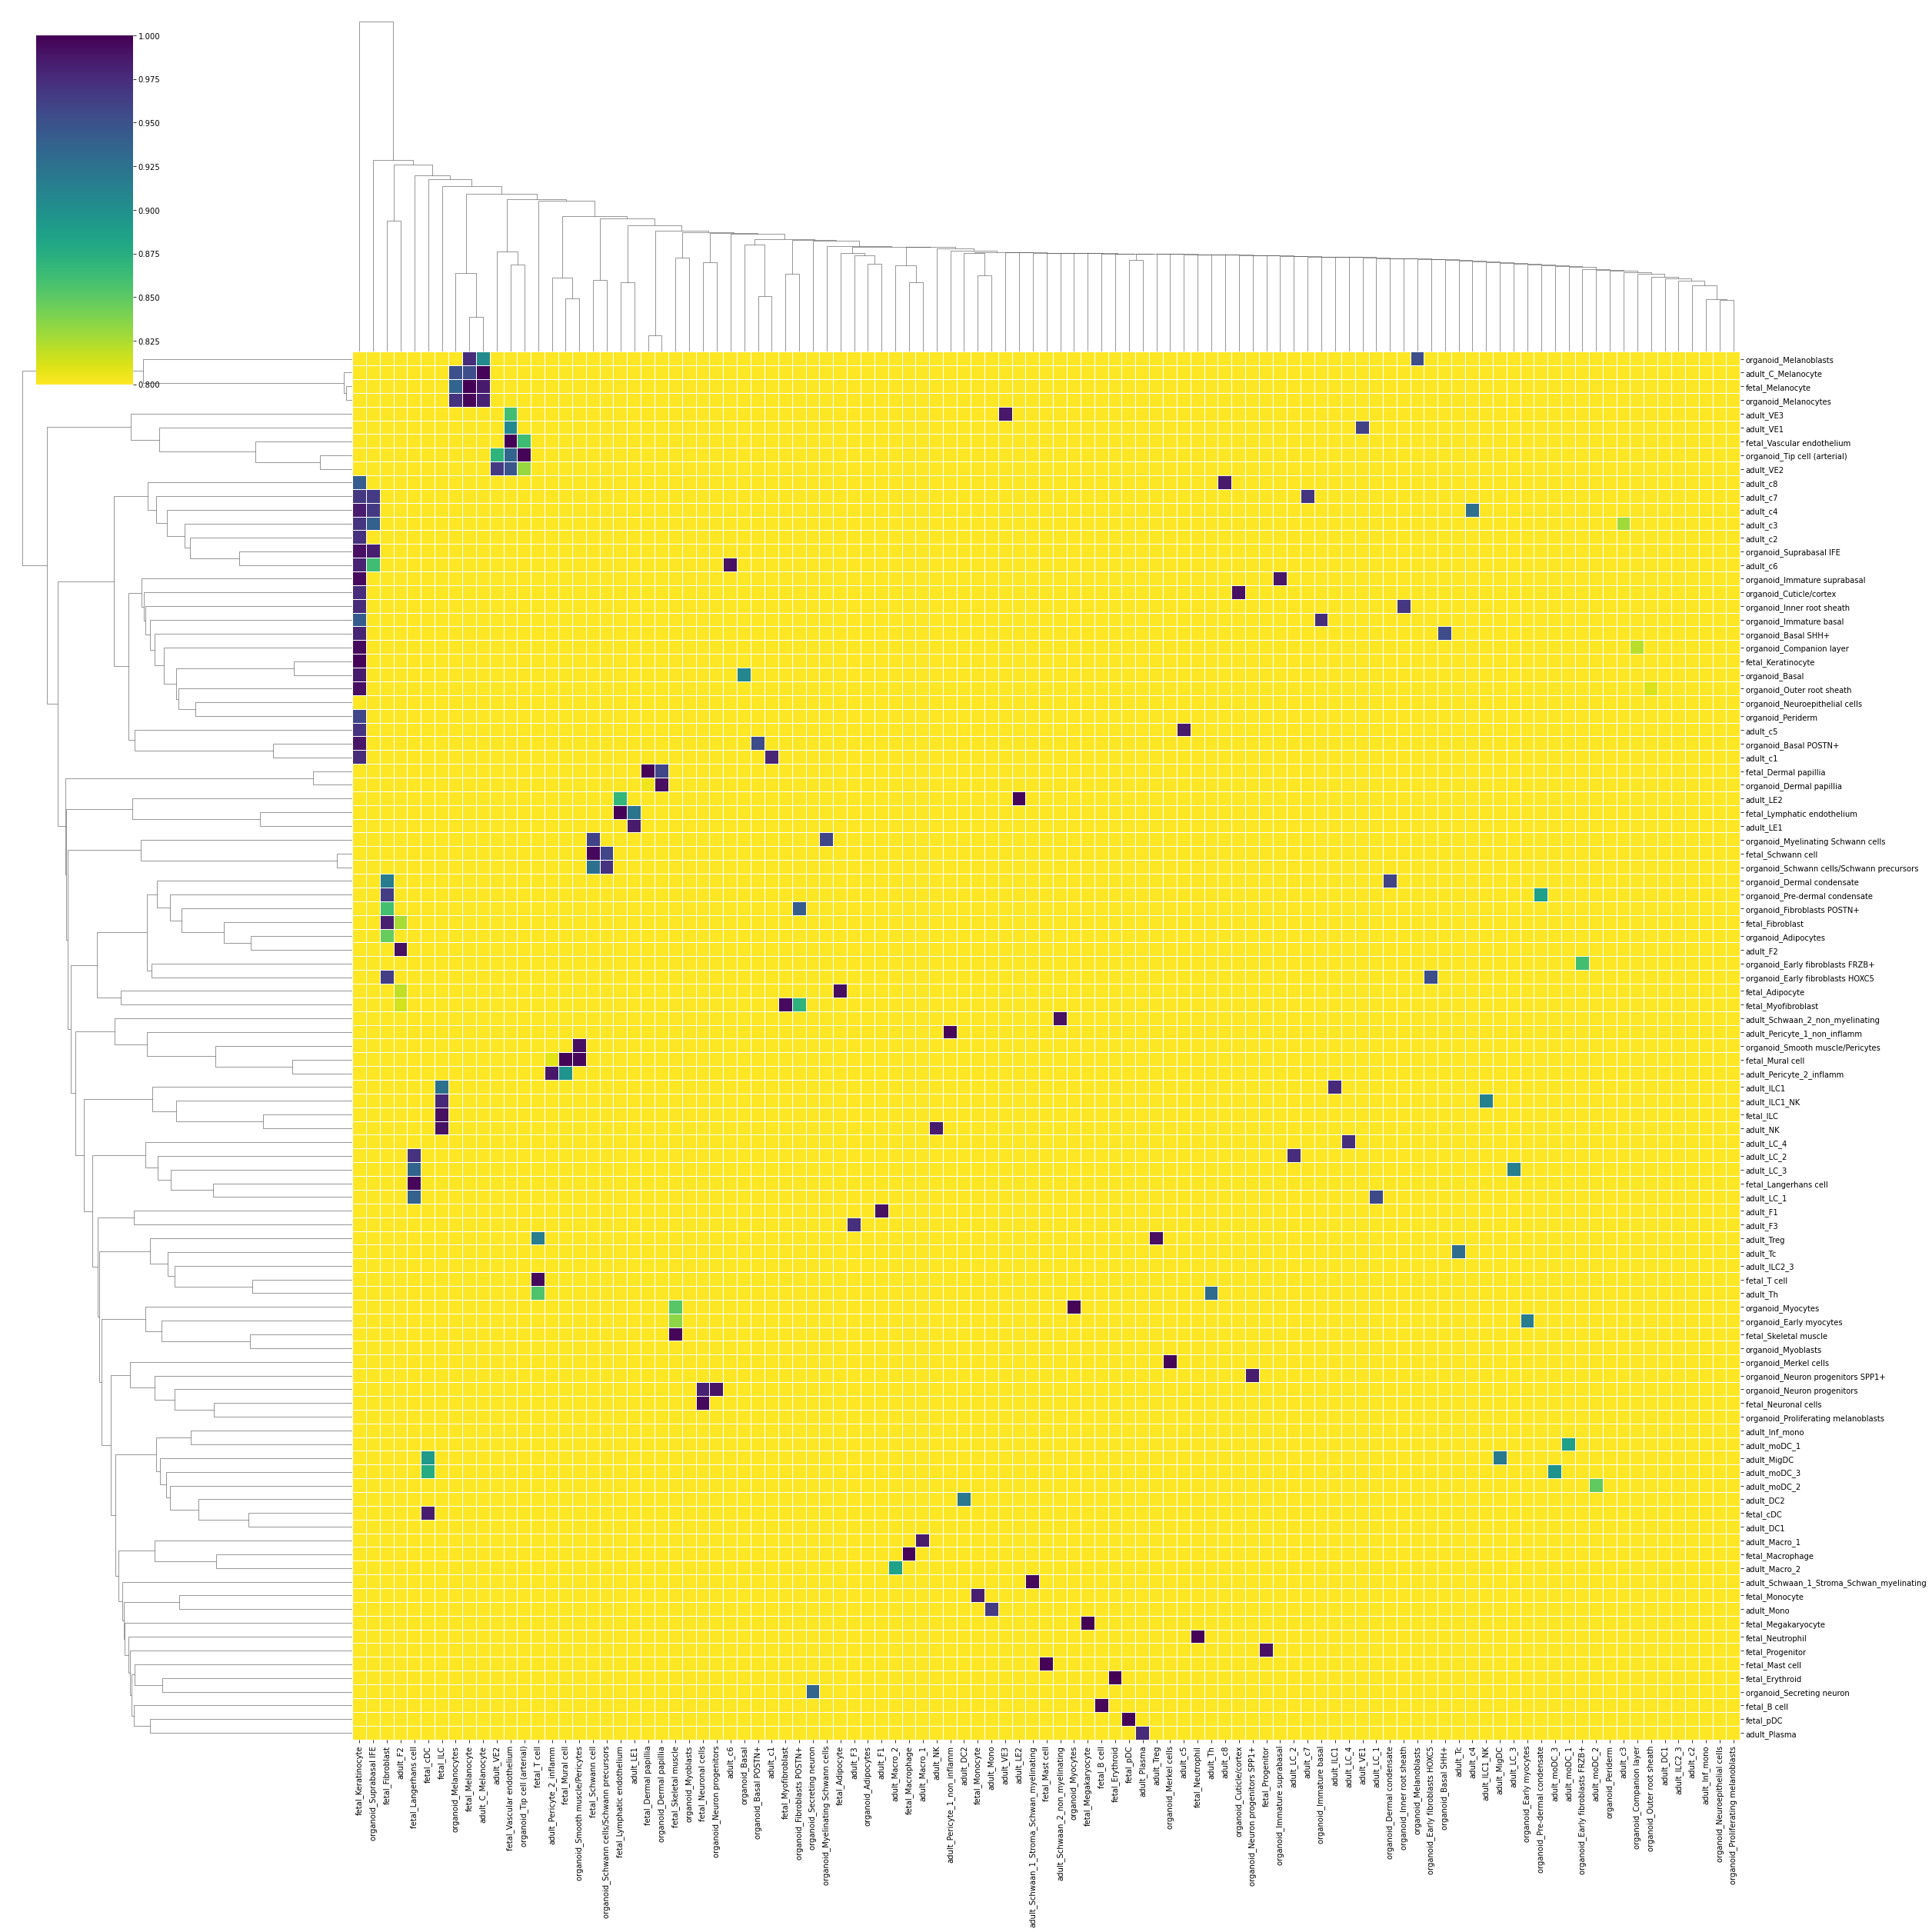

In [164]:
sn.clustermap(final_df1, cmap="viridis_r", linewidth=0.01, figsize=(35, 35), vmin=0.8, vmax=1);

In [35]:
predictions = joblib.load("ask_fsk_org.celltype_predictions.20220208.pkl")

In [ ]:
predictions["adult"]["fetal"]["prob"]

,adult_B,adult_C_Melanocyte,adult_DC1,adult_DC2,adult_F1,adult_F2,adult_F3,adult_ILC1,adult_ILC1_NK,adult_ILC2_3,...,adult_c3,adult_c4,adult_c5,adult_c6,adult_c7,adult_c8,adult_moDC_1,adult_moDC_2,adult_moDC_3,adult_pDC
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGGTCAGTGGA-1-4834STDY7002879,0.001345,0.013358,0.000961,0.001661,0.000187,0.003764,0.000739,0.000339,0.003055,0.005084,...,0.000694,0.007265,0.000190,0.000515,0.000120,0.000024,5.759765e-07,6.344421e-06,0.001613,0.002651
AAAGATGGTCGATTGT-1-4834STDY7002879,0.007119,0.005988,0.018890,0.114497,0.000921,0.013281,0.001847,0.019193,0.013572,0.018952,...,0.001354,0.003098,0.000686,0.002983,0.000202,0.000178,6.041154e-05,1.113782e-04,0.003822,0.008458
AAAGCAAAGATGTGGC-1-4834STDY7002879,0.000904,0.001073,0.001053,0.002213,0.000181,0.000893,0.000717,0.000484,0.001066,0.000809,...,0.000310,0.001997,0.000173,0.000791,0.000024,0.000016,1.220633e-06,4.973177e-06,0.000162,0.003223
AAAGTAGCAGATCGGA-1-4834STDY7002879,0.008527,0.014117,0.016474,0.014591,0.001030,0.016482,0.013777,0.014076,0.017168,0.033355,...,0.001684,0.014420,0.003745,0.002169,0.000847,0.000276,2.916643e-06,2.975918e-05,0.001119,0.030697
AAAGTAGTCCGCATCT-1-4834STDY7002879,0.001011,0.009585,0.002904,0.001465,0.000477,0.008867,0.000658,0.001250,0.001031,0.001408,...,0.000125,0.000944,0.000478,0.000409,0.000088,0.000080,3.078284e-06,3.049498e-05,0.000628,0.002858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGTGAACGC-1-FCAImmP7964510,0.002975,0.047807,0.004387,0.000137,0.000457,0.029284,0.009957,0.001533,0.002468,0.002094,...,0.001459,0.007262,0.002195,0.000654,0.000541,0.000024,2.925821e-07,3.353840e-05,0.002149,0.002283
TTTGTCAGTGCGAAAC-1-FCAImmP7964510,0.001658,0.036173,0.004141,0.000286,0.000787,0.022753,0.003556,0.000777,0.002427,0.001276,...,0.000523,0.002377,0.001412,0.000630,0.000162,0.000099,2.494695e-07,4.919354e-06,0.000891,0.001244
TTTGTCATCCATGAGT-1-FCAImmP7964510,0.006436,0.111122,0.004035,0.007837,0.030299,0.025868,0.001244,0.006768,0.047132,0.011361,...,0.000263,0.011445,0.005636,0.034324,0.004157,0.019993,2.336248e-03,4.393454e-04,0.031549,0.015569


### Visualisation

In [112]:
umap_obj = umap.UMAP(n_neighbors=5, metric="precomputed")
ct_umap_df = pd.DataFrame(
    umap_obj.fit_transform(1 - final_df1.values), index=final_df1.index, columns=["UMAP1", "UMAP2"]
)

In [115]:
ct_umap_df["dataset"] = ct_umap_df.index.to_series().str.partition("_")[0].values

In [121]:
ct_umap_df["celltype"] = ct_umap_df.index.to_series().str.partition("_")[2].values

In [123]:
ct_umap_df.reset_index().to_csv("fig1D_a.csv", index=False)

In [ ]:
%%R

loadPackage(tidyverse)
loadPackage(ggrepel)

df < -read_csv("fig1D_a.csv")
pdf(file="fig1D_a.20220208.pdf", height=9, width=9)
print(
    ggplot(df, aes(x=UMAP1, y=UMAP2, label=celltype, color=dataset))
    + geom_point()
    + geom_text_repel(size=3)
    + theme_classic()
)
dev.off()

![title](fig1D_a.20220208.png)

In [50]:
predictions["adult"]["fetal"]["prob"].columns

Index(['adult_B', 'adult_C_Melanocyte', 'adult_DC1', 'adult_DC2', 'adult_F1',
       'adult_F2', 'adult_F3', 'adult_ILC1', 'adult_ILC1_NK', 'adult_ILC2_3',
       'adult_Inf_mono', 'adult_LC_1', 'adult_LC_2', 'adult_LC_3',
       'adult_LC_4', 'adult_LE1', 'adult_LE2', 'adult_Macro_1',
       'adult_Macro_2', 'adult_Mast', 'adult_MigDC', 'adult_Mono', 'adult_NK',
       'adult_Pericyte_1_non_inflamm', 'adult_Pericyte_2_inflamm',
       'adult_Plasma', 'adult_Schwaan_1_Stroma_Schwan_myelinating',
       'adult_Schwaan_2_non_myelinating', 'adult_Schwann', 'adult_Tc',
       'adult_Th', 'adult_Treg', 'adult_VE1', 'adult_VE2', 'adult_VE3',
       'adult_c1', 'adult_c2', 'adult_c3', 'adult_c4', 'adult_c5', 'adult_c6',
       'adult_c7', 'adult_c8', 'adult_moDC_1', 'adult_moDC_2', 'adult_moDC_3',
       'adult_pDC'],
      dtype='object')

In [137]:
adult_annot_df = pd.DataFrame(
    {
        "refined": [
            "adult_B",
            "adult_C_Melanocyte",
            "adult_DC1",
            "adult_DC2",
            "adult_F1",
            "adult_F2",
            "adult_F3",
            "adult_ILC1",
            "adult_ILC1_NK",
            "adult_ILC2_3",
            "adult_Inf_mono",
            "adult_LC_1",
            "adult_LC_2",
            "adult_LC_3",
            "adult_LC_4",
            "adult_LE1",
            "adult_LE2",
            "adult_Macro_1",
            "adult_Macro_2",
            "adult_Mast",
            "adult_M_A_Mast_cell",
            "adult_MigDC",
            "adult_Mono",
            "adult_NK",
            "adult_Pericyte_1_non_inflamm",
            "adult_Pericyte_2_inflamm",
            "adult_Plasma",
            "adult_Schwaan_1_Stroma_Schwan_myelinating",
            "adult_Schwaan_2_non_myelinating",
            "adult_Schwann",
            "adult_Tc",
            "adult_Th",
            "adult_Treg",
            "adult_VE1",
            "adult_VE2",
            "adult_VE3",
            "adult_c1",
            "adult_c2",
            "adult_c3",
            "adult_c4",
            "adult_c5",
            "adult_c6",
            "adult_c7",
            "adult_c8",
            "adult_moDC_1",
            "adult_moDC_2",
            "adult_moDC_3",
            "adult_pDC",
        ],
        "broad": [
            "adult_B",
            "adult_Melanocyte",
            "adult_cDC",
            "adult_cDC",
            "adult_Fibro",
            "adult_Fibro",
            "adult_Fibro",
            "adult_ILC",
            "adult_ILC",
            "adult_ILC",
            "adult_Mono",
            "adult_LC",
            "adult_LC",
            "adult_LC",
            "adult_LC",
            "adult_LE",
            "adult_LE",
            "adult_Macro",
            "adult_Macro",
            "adult_Mast",
            "adult_Mast",
            "adult_DC",
            "adult_Mono",
            "adult_NK",
            "adult_Pericyte",
            "adult_Pericyte",
            "adult_Plasma",
            "adult_Schwaan",
            "adult_Schwaan",
            "adult_Schwann",
            "adult_T",
            "adult_T",
            "adult_T",
            "adult_VE",
            "adult_VE",
            "adult_VE",
            "adult_Keratinocyte",
            "adult_Keratinocyte",
            "adult_Keratinocyte",
            "adult_Keratinocyte",
            "adult_Keratinocyte",
            "adult_Keratinocyte",
            "adult_Keratinocyte",
            "adult_Keratinocyte",
            "adult_cDC",
            "adult_cDC",
            "adult_cDC",
            "adult_pDC",
        ],
    }
)

In [54]:
predictions["organoid"]["fetal"]["prob"].columns

Index(['organoid_Adipocytes', 'organoid_Basal', 'organoid_Basal POSTN+',
       'organoid_Basal SHH+', 'organoid_Companion layer',
       'organoid_Cuticle/cortex', 'organoid_Dermal condensate',
       'organoid_Dermal papillia', 'organoid_Early fibroblasts FRZB+',
       'organoid_Early fibroblasts HOXC5', 'organoid_Early myocytes',
       'organoid_Fibroblasts POSTN+', 'organoid_Immature basal',
       'organoid_Immature suprabasal', 'organoid_Inner root sheath',
       'organoid_Melanoblasts', 'organoid_Melanocytes',
       'organoid_Merkel cells', 'organoid_Myelinating Schwann cells',
       'organoid_Myoblasts', 'organoid_Myocytes',
       'organoid_Neuroepithelial cells', 'organoid_Neuron progenitors',
       'organoid_Neuron progenitors SPP1+', 'organoid_Outer root sheath',
       'organoid_Periderm', 'organoid_Pre-dermal condensate',
       'organoid_Proliferating melanoblasts',
       'organoid_Schwann cells/Schwann precursors',
       'organoid_Secreting neuron', 'organoid_Sm

In [55]:
organoid_annot_df = pd.DataFrame(
    {
        "refined": [
            "organoid_Adipocytes",
            "organoid_Basal",
            "organoid_Basal POSTN+",
            "organoid_Basal SHH+",
            "organoid_Companion layer",
            "organoid_Cuticle/cortex",
            "organoid_Dermal condensate",
            "organoid_Dermal papillia",
            "organoid_Early fibroblasts FRZB+",
            "organoid_Early fibroblasts HOXC5",
            "organoid_Early myocytes",
            "organoid_Fibroblasts POSTN+",
            "organoid_Immature basal",
            "organoid_Immature suprabasal",
            "organoid_Inner root sheath",
            "organoid_Melanoblasts",
            "organoid_Melanocytes",
            "organoid_Merkel cells",
            "organoid_Myelinating Schwann cells",
            "organoid_Myoblasts",
            "organoid_Myocytes",
            "organoid_Neuroepithelial cells",
            "organoid_Neuron progenitors",
            "organoid_Neuron progenitors SPP1+",
            "organoid_Outer root sheath",
            "organoid_Periderm",
            "organoid_Pre-dermal condensate",
            "organoid_Proliferating melanoblasts",
            "organoid_Schwann cells/Schwann precursors",
            "organoid_Secreting neuron",
            "organoid_Smooth muscle/Pericytes",
            "organoid_Suprabasal IFE",
            "organoid_Tip cell (arterial)",
        ],
        "broad": [
            "organoid_Adipocyte",
            "organoid_Keratinocyte",
            "organoid_Keratinocyte",
            "organoid_Keratinocyte",
            "organoid_Keratinocyte",
            "organoid_Keratinocyte",
            "organoid_Fibro",
            "organoid_Fibro",
            "organoid_Fibro",
            "organoid_Fibro",
            "organoid_Myocyte",
            "organoid_Fibro",
            "organoid_Keratinocyte",
            "organoid_Keratinocyte",
            "organoid_Keratinocyte",
            "organoid_Melanocyte",
            "organoid_Melanocyte",
            "organoid_Merkel",
            "organoid_Schwann",
            "organoid_Myocyte",
            "organoid_Myocyte",
            "organoid_Neuroepithelial",
            "organoid_Neuronal",
            "organoid_Neuronal",
            "organoid_Keratinocyte",
            "organoid_Keratinocyte",
            "organoid_Fibro",
            "organoid_Melanocyte",
            "organoid_Schwann",
            "organoid_Neuronal",
            "organoid_Mural",
            "organoid_Keratinocyte",
            "organoid_VE",
        ],
    }
)

In [56]:
organoid_annot_df["broad"] = organoid_annot_df.broad.astype("category")

In [141]:
adult_annot_df["broad"] = adult_annot_df.broad.astype("category")

In [58]:
pred_prob = predictions["adult"]["organoid"]["prob"].copy()

In [ ]:
ds2 = "adult"

ad = ads[ds2]

annot_srs = ad.obs[annots[ds2]]

pd.DataFrame(annot_srs).reset_index().merge(
    adult_annot_df, how="left", left_on=annots[ds2], right_on="refined"
).set_index("index")["broad"]

In [142]:
final_dfs2 = []
for ds1, lr in models.items():
    pred_dfs = []
    for ds2, ad in ads.items():
        pred_prob = predictions[ds1][ds2]["prob"].copy()
        if ds1 == "adult":
            pred_prob = pd.DataFrame(
                npg.aggregate_np(
                    adult_annot_df.broad.cat.codes,
                    pred_prob.values.T,
                    func="sum",
                    axis=0,
                ).T,
                index=pred_prob.index,
                columns=adult_annot_df.broad.cat.categories,
            )
        elif ds1 == "organoid":
            pred_prob = pd.DataFrame(
                npg.aggregate_np(
                    organoid_annot_df.broad.cat.codes,
                    pred_prob.values.T,
                    func="sum",
                    axis=0,
                ).T,
                index=pred_prob.index,
                columns=organoid_annot_df.broad.cat.categories,
            )

        annot_srs = ad.obs[annots[ds2]].copy()
        if ds2 == "adult":
            annot_srs = (
                pd.DataFrame(annot_srs)
                .reset_index()
                .merge(adult_annot_df, how="left", left_on=annots[ds2], right_on="refined")
                .set_index("index")["broad"]
            )
        elif ds2 == "organoid":
            annot_srs = (
                pd.DataFrame(annot_srs)
                .reset_index()
                .merge(organoid_annot_df, how="left", left_on=annots[ds2], right_on="refined")
                .set_index("index")["broad"]
            )

        pred_df = pd.DataFrame(
            npg.aggregate_np(
                annot_srs.cat.codes,
                pred_prob.values,
                func=np.median,
                axis=0,
            ),
            index=annot_srs.cat.categories,
            columns=pred_prob.columns,
        )
        if not pred_df.index[0].startswith(ds2):
            pred_df.index = f"{ds2}_" + pred_df.index.astype(str)
        pred_dfs.append(pred_df)
    final_dfs2.append(pd.concat(pred_dfs, axis=0))

ValueError: Shape of passed values is (19, 25), indices imply (20, 25)

In [157]:
adt_ad.obs.anno_final.cat.categories

Index(['adult_C_Melanocyte', 'adult_DC1', 'adult_DC2', 'adult_F1', 'adult_F2',
       'adult_F3', 'adult_ILC1', 'adult_ILC1_NK', 'adult_ILC2_3',
       'adult_Inf_mono', 'adult_LC_1', 'adult_LC_2', 'adult_LC_3',
       'adult_LC_4', 'adult_LE1', 'adult_LE2', 'adult_M_A_Mast_cell',
       'adult_Macro_1', 'adult_Macro_2', 'adult_MigDC', 'adult_Mono',
       'adult_NK', 'adult_Pericyte_1_non_inflamm', 'adult_Pericyte_2_inflamm',
       'adult_Plasma', 'adult_Schwaan_1_Stroma_Schwan_myelinating',
       'adult_Schwaan_2_non_myelinating', 'adult_Tc', 'adult_Th', 'adult_Treg',
       'adult_VE1', 'adult_VE2', 'adult_VE3', 'adult_c1', 'adult_c2',
       'adult_c3', 'adult_c4', 'adult_c5', 'adult_c6', 'adult_c7', 'adult_c8',
       'adult_moDC_1', 'adult_moDC_2', 'adult_moDC_3'],
      dtype='object')

In [155]:
annot_srs.cat.codes.unique().

array([ 4,  9,  6,  2,  5, 16, 17, 11,  7,  3, 13, 18, 10,  1, 12, 14,  8], dtype=int8)

In [152]:
adult_annot_df.broad.cat.categories

Index(['adult_B', 'adult_DC', 'adult_Fibro', 'adult_ILC', 'adult_Keratinocyte',
       'adult_LC', 'adult_LE', 'adult_Macro', 'adult_Mast', 'adult_Melanocyte',
       'adult_Mono', 'adult_NK', 'adult_Pericyte', 'adult_Plasma',
       'adult_Schwaan', 'adult_Schwann', 'adult_T', 'adult_VE', 'adult_cDC',
       'adult_pDC'],
      dtype='object')

In [150]:
annot_srs.cat.categories

Index(['adult_B', 'adult_DC', 'adult_Fibro', 'adult_ILC', 'adult_Keratinocyte',
       'adult_LC', 'adult_LE', 'adult_Macro', 'adult_Mast', 'adult_Melanocyte',
       'adult_Mono', 'adult_NK', 'adult_Pericyte', 'adult_Plasma',
       'adult_Schwaan', 'adult_Schwann', 'adult_T', 'adult_VE', 'adult_cDC',
       'adult_pDC'],
      dtype='object')

In [146]:
pred_prob.columns.size

25

In [143]:
ds1, ds2

('fetal', 'adult')

In [145]:
pred_prob.shape

(195739, 25)

In [116]:
annot_srs.cat.codes

index
AAACCTGAGAGTGACC-1-SKN8104894          4
AAACCTGAGGTCGGAT-1-SKN8104894          4
AAACCTGAGTCGAGTG-1-SKN8104894          4
AAACCTGCATACTCTT-1-SKN8104894          4
AAACCTGCATTCACTT-1-SKN8104894          9
                                      ..
TTTGGTTTCAGGCCCA-1-4820STDY7389014     5
TTTGGTTTCGCCTGTT-1-4820STDY7389014    16
TTTGTCAAGGAATCGC-1-4820STDY7389014    16
TTTGTCAAGGACTGGT-1-4820STDY7389014     3
TTTGTCACACTACAGT-1-4820STDY7389014    16
Length: 195739, dtype: int8

## Part2

In [133]:
predictions["adult"]["fetal"].keys()

dict_keys(['label', 'prob'])

# Save

In [137]:
final_df1.to_csv("ask_fsk_org.celltype_similarity.20220208.csv")

In [162]:
final_df1 = pd.read_csv("ask_fsk_org.celltype_similarity.20220208.csv", index_col=0)

In [138]:
joblib.dump(predictions, "ask_fsk_org.celltype_predictions.20220208.pkl", compress=True)

['ask_fsk_org.celltype_predictions.20220208.pkl']